# Predict Future Beta of Each Stock to SPY 

Tashalee Billings

In [129]:
%%time 
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import platform, copy

from importlib import import_module
from platform import python_version
from numpy.random import seed
seed(42)

# ML Library
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow import keras
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler

# set font size
sns.set(font_scale=2)
"""
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

"""
# Stocks I will work with in this notebook
ticker_symbol = ["AAPL"]#["AAPL","AMZN", "GOOG", "TSLA", "TWTR"]
sp500 = "SPY"

days = 45
factor = 17
training_data_len = days*factor
new_shape = (factor,days)
new_shape_test = (2,days)

path2trainingdata = "../Downloads/beta_project_data.csv"

CPU times: user 4.22 ms, sys: 35.9 ms, total: 40.2 ms
Wall time: 79 ms


#### SOFTWARE
Print the version of different softwares used in this analysis.

In [534]:
print("Python Version:\n \t",platform.sys.version)

for module in ["numpy", "tensorflow", "matplotlib", "sklearn"]:
    try:
        _mdl = import_module(module)
    except ModuleNotFoundError:
        pass
    
    if hasattr(_mdl, 'version'):
        gh = getattr(_mdl.version, 'git_hash', None)
    print("Module {:<11}....\tVersion {:<7}.......\tGit {}".format(module, _mdl.__version__, gh))

Python Version:
 	 3.6.13 | packaged by conda-forge | (default, Sep 23 2021, 07:55:15) 
[GCC Clang 11.1.0]
Module numpy      ....	Version 1.19.5 .......	Git None
Module tensorflow ....	Version 2.6.0  .......	Git None
Module matplotlib ....	Version 3.3.4  .......	Git None
Module sklearn    ....	Version 0.24.2 .......	Git None


# BACKGROUND
This section focuses on back information. I am not familiar with the topics so lets sketch out what I think it means.

### PROBLEM STATEMENT  

We want you to build a model that can predict the future beta of a stock to the S&P 500. You will be provided with a dataset containing stock data, such as close price and volume. Build a model that will predict the future beta of each stock in the dataset to “SPY” (the symbol “SPY” is in the dataset). For day T, you should forecast the 45-day forward-looking beta (which is calculated using days T+1 through T+45). We will apply your model to some out-of-sample data, as well, so please make it easy for a new dataset to be scored with the model. Following your completion of the project we will set up a video chat where you will walk us through your approach.    

### HINTS
- If you are not familiar you should look up the formula for beta, it is ultimately the ratio of covariance to variance of the percent changes in stock price.  
- We recommend starting with MSE as an objective function, but feel free to experiment if you have a good reason to modify it.  
- You may find the pandas rolling and shift functions useful in this project.  
- “Adjustment Factor” is used to deal with dividends and stock splits.  

$Y = X\beta + \epsilon$.  
What assumptions are being made? How would you calculate $\beta$? What tests can be done on afterwards?  


#### DEFINITION OF BETA
**Definition**: A **beta** coefficient can measure the volatility of an individual stock compared to the systematic risk of the entire market. That is to say, it effectively describes the activity of a security's returns as it responds to swings in the market.  

It might be insightful to write down different definitions of this word.  
    1. Statistics Definition: **beta** represents the slope of the line through a regression of data points.  
    2. Finance: **beta** represents the slope of the line through an individual stock's returns against those of the market as a whole regression of data points.  
    
It is important to emphasize that this **beta** term tells investors how much risk a stock is adding to a portfolio. Stocks that deviates very little from the market do not add a lot of risk to a portfolio AND it does not increase the potential for greater returns.  

In order to make sure that a specific stock is being compared to the right benchmark, it should have a high R-squared value in relation to the benchmark. R-squared is a statistical measure that shows the percentage of a security's historical price movements that can be explained by movements in the benchmark index. When using beta to determine the degree of systematic risk, a security with a high R-squared value, in relation to its benchmark, could indicate a more relevant benchmark.
 
#### Types of Beta
Now, lets think about the types of values **beta** can take on and what they mean. This should be useful when interpreting results.    

$\color{red}{\text{Beta Value Equal to 1.0}}$  
If a stock has a beta of 1.0, it indicates that its price activity is strongly correlated with the market. A stock with a beta of 1.0 has systematic risk.  

$\color{red}{\text{Beta Value Equal less than 1.0}}$  
A beta value that is less than 1.0 means that the security is theoretically less volatile than the market. Including this stock in a portfolio makes it less risky than the same portfolio without the stock.  

$\color{red}{\text{Beta Value Equal greater than 1.0}}$  
A beta that is greater than 1.0 indicates that the security's price is theoretically more volatile than the market. For example, if a stock's beta is 1.2, it is assumed to be 20% more volatile than the market. 

$\color{red}{\text{Negative Beta Value}}$   
Some stocks have negative betas. A beta of -1.0 means that the stock is inversely correlated to the market benchmark on a 1:1 basis. This stock could be thought of as an opposite, mirror image of the benchmark’s trends. Put options and inverse ETFs are designed to have negative betas. There are also a few industry groups, like gold miners, where a negative beta is also common.


#### Other Features

I see a lot of comparison to volitility and this CAPM. So, lets define them!  

**Volatility** is simply the following. It allows us to predict how much a stock price will change in the future compared to the overall stock market. A higher volatility means it is a riskier stock and is more likely to have greater changes, either up or down, in the future.  

**Capital Asset Pricing Model (CAPM)** simultaneously simplified Markowitz’s Modern Portfolio Theory (MPT) by making it more practical and introduced the idea of specific and systematic risk. Whereas MPT has arbitrary correlation between all investments, CAPM, in its basic form, only links investments via the market as a whole.
CAPM is an example of an equilibrium model, as opposed to a no-arbitrage model such as Black–Scholes. The mathematics of CAPM is very simple. We relate the random return on the ith investment, $R_i$, to the random return on the market as a whole (or some representative
index), $R_M$ by,   

\begin{equation*}
\LARGE R_i = \alpha_i + \beta_i R_m + \epsilon_i
\label{eq:linear_relation} \tag{1}
\end{equation*}

The $\epsilon_i$ is random with zero mean and standard deviation $e_i$, and uncorrelated with the market return $R_M$ and the other $\epsilon_j$ . "Smells" like an error term.  

There are three parameters associated with each asset, $\alpha_i$, $\beta_i$ and $e_i$. In this representation we can see that the return on an asset can be decomposed into three parts:  
    1. A constant drift   
    2. A random part common with the index   
    3. A random part uncorrelated with the index, $\epsilon_i$   
    

All the assets are related to the index but are otherwise completely uncorrelated.

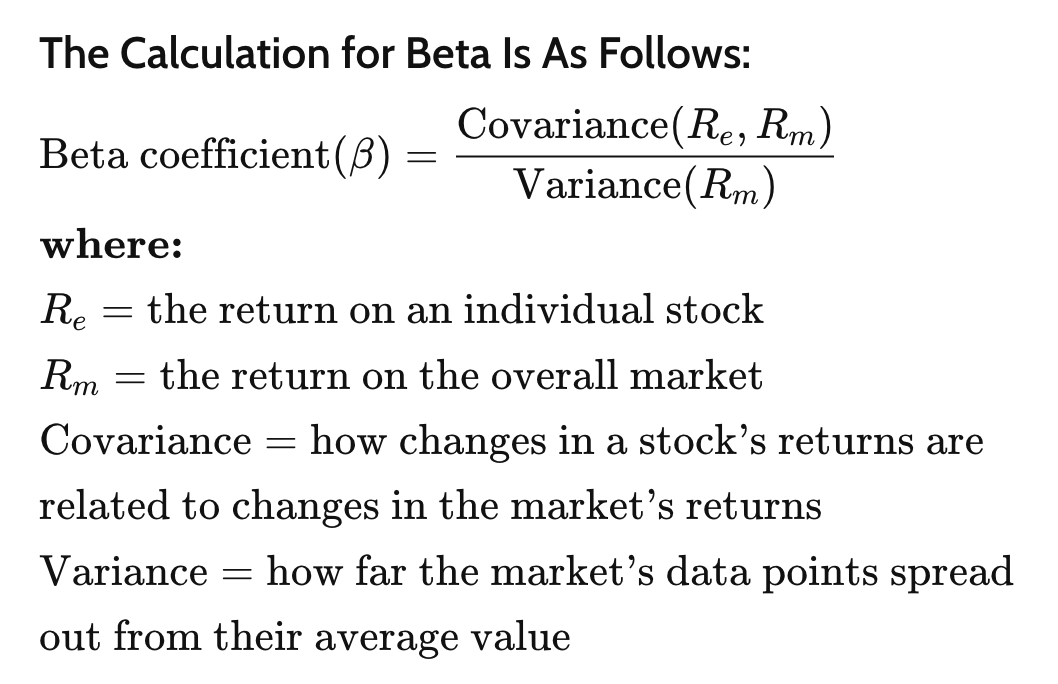

*Reference*: https://www.investopedia.com/terms/b/beta.asp

### ASSUMPTIONS
https://corporatefinanceinstitute.com/resources/data-science/beta-coefficient/  
1. The beta coefficient theory assumes that stock returns are normally distributed from a statistical perspective.   
2. The return on the ith investment or individual stock, R_e, is a random variable.  
3. The return on the market as a whole, R_M, is also a random variable.   

In order to make sure that a specific stock is being compared to the right benchmark, it should have a high R-squared value in relation to the benchmark. R-squared is a statistical measure that shows the percentage of a security's historical price movements that can be explained by movements in the benchmark index. When using beta to determine the degree of systematic risk, a security with a high R-squared value, in relation to its benchmark, could indicate a more relevant benchmark.  


### DRAWBACKS TO USING BETA

Beta calculation can’t detect any unsystematic risk. Adding a stock to a portfolio with a beta of 1.0 doesn’t add any risk to the portfolio, but it also doesn’t increase the likelihood that the portfolio will provide an excess return.  

Technology stocks and small cap stocks tend to have higher betas than the market benchmark. This indicates that adding the stock to a portfolio will increase the portfolio’s risk, but may also increase its expected return.   



Drawbacks of Beta  
Beta is useful in determining a security's short-term risk, and for analyzing volatility to arrive at equity costs when using the CAPM. However, since beta is calculated using historical data points, it becomes less meaningful for investors looking to predict a stock's future movements. Beta is also less useful for long-term investments since a stock's volatility can change significantly from year to year, depending upon the company's growth stage and other factors. Furthermore, the beta measure on a particular stock's tendency to jump around over time, which makes it unreliable as a stable measure.  


Is Beta a Good Measure of Risk?  
Many experts agree that while Beta provides some information about risk, it is not an effective measure of risk on its own. Beta only looks at a stock's past performance relative to the S&P 500 and does not provide any forward guidance. It also does not consider the fundamentals of a company or its earnings and growth potential.   

# APPROACH TO SOLVING THE PROBLEM
I will try two different kinds just to see what happens. First, I will use OLS method and then I will try LSTM Model...

UPDATE: I did not try OLS method. I ran out of time because I needed to get a model running and then make sure this notebook makes sense to someone reading it. Then I needed to add notes throughout because I want you know know what I'm thinking. Normally if I were making a notebook for myself I wouldn't write this much.


In [224]:
def STOCK_df(DataFrame, ticker_symbol):
    """
    PARAMETERS:
    DATAFRAME: Pandas data structure that has already been loaded [DataFrame]
    TICKER_SYMBOL: The stock ticker symbol [sting]
    
    RETURN: Standard DataFrame
    
    EXAMPLE
    STOCK_df(DataFrame=df, ticker_symbol="AAPL")
    
    """
    return DataFrame[DataFrame["Symbol"]==ticker_symbol]

def buildAdjustClosingColumn(DataFrame, ticker_symbol=None):
    # https://www.investopedia.com/ask/answers/06/adjustedclosingprice.asp
    # Multiply closing price by the adjustment factor I was given a fractional number
    """
    I tried to make this function slightly flexible in the sense that if you've already forced the dataframe to have
    only one stock then just go ahead and return the dataframe with with the added column.
    
    If this is not the case and you pass a dataframe with multiple stocks you'll have to specify the ticker.
    
    
    PARAMETERS:
    DATAFRAME: Pandas data structure that has already been loaded [DataFrame]
    TICKER_SYMBOL: The stock ticker symbol [sting]
    
    RETURN: Standard DataFrame
    """
    if len(DataFrame.Symbol.unique().tolist()) == 1: # checks that you only have one stock
        #Doesn't look for empty DataFrame
        DataFrame["AdjustedClose"] = DataFrame.Close * DataFrame["Adjustment Factor"]
        print(DataFrame)        
        return DataFrame
        
    else:
        if ticker_symbol != None: # check that you actually specified a ticker but not necessarily a valid ticker
            # that's left to you to make sure
            DataFrame["AdjustedClose"] = DataFrame[DataFrame["Symbol"]==ticker_symbol]["Close"]*(
                DataFrame[DataFrame["Symbol"]==ticker_symbol]["Adjustment Factor"])
            print(DataFrame)
    return DataFrame

def orderStockByDate(DataFrame):
    # https://www.easytweaks.com/sort-dataframe-dates-month-years/
    
    # Convert our date column to the datetime64 type
    DataFrame['Date'] = DataFrame['Date'].astype('datetime64')
    
    # sort dates according to ascending dates (earliest first)
    DataFrame.sort_values(by='Date').reset_index(drop=True)
    
    # make new columns
    DataFrame['month'] = DataFrame['Date'].dt.month
    DataFrame['day'] = DataFrame['Date'].dt.day
    DataFrame['year'] = DataFrame['Date'].dt.year
    
    #Order our data by multiple column values we can simply pass a list of columns to the sort() method
    # First pick the year, then the month, then the days in that month
    DataFrame = DataFrame.sort_values(['year','month', 'day']).reset_index(drop=True)
    
    return DataFrame
    


def buildStockReturnsColumn(DataFrame, window=45, ticker_symbol=None):
    # https://www.youtube.com/watch?v=zlClflcSrM8
    # Helped me calculate the adjusted returns
    """
    I tried to make this function slightly flexible in the sense that if you've already forced the dataframe to have
    only one stock then just go ahead and return the dataframe with with the added column.
    
    If this is not the case and you pass a dataframe with multiple stocks you'll have to specify the ticker.
    
    Also, it's important that in order to calculate the returns the data must be sorted in order by its date.
    
    PARAMETERS:
    DATAFRAME: Pandas data structure that has already been loaded [DataFrame]
    TICKER_SYMBOL: The stock ticker symbol [sting]
    
    RETURN: DataFrame Sorted by Date
    
    """
    if len(DataFrame.Symbol.unique().tolist()) == 1 and "AdjustedClose" in DataFrame.columns and "year" in DataFrame.columns: 
        # checks that you only have one stock and that you created an "AdjustedClose" already
        # checks that column name is there because that assumes youve ordred the stock by dates
        # Doesn't look for empty DataFrame...
        
        DataFrame["AdjustedReturns"] = DataFrame.AdjustedClose.rolling(window=window).sum()
        print(DataFrame.dropna())        
        return DataFrame.dropna()
    

def beta(stock_returns_array,sp500_returns_array):
    # https://www.youtube.com/watch?v=zlClflcSrM8
    import numpy as np
    
    cov = np.cov(sp500_returns_array, stock_returns_array, ddof=0 )[0][1]
    std_sp500 = np.cov(sp500_returns_array, stock_returns_array, ddof=0 )[1][1]
    
    return cov/std_sp500
    



In [666]:
df

,Code,Symbol,Date,Close,Volume,Adjustment Factor
0,59776,IBB,6/6/2014,246.09,674915.0,1.0
1,59593,AET,10/4/2012,42.09,7327759.0,1.0
2,57850,TXN,10/12/2015,51.34,4075340.0,1.0
3,62606,WW,4/23/2014,21.18,590148.0,1.0
4,59750,MDY,8/17/2010,135.89,2854263.0,1.0
...,...,...,...,...,...,...
291339,50183,IBM,12/27/2011,184.95,2775314.0,1.0
291340,43096,ABT,7/26/2011,52.18,5863457.0,1.0
291341,96139,EXPE,7/30/2014,81.68,2729537.0,1.0
291342,58577,VZ,9/4/2014,49.72,9473532.0,1.0


In [589]:
len(df.Symbol.unique().tolist())

201

In [676]:
df.groupby("Symbol", group_keys=False).apply(lambda x: x)[["Code", "Symbol"]]

,Code,Symbol
0,59776,IBB
1,59593,AET
2,57850,TXN
3,62606,WW
4,59750,MDY
...,...,...
291339,50183,IBM
291340,43096,ABT
291341,96139,EXPE
291342,58577,VZ


In [685]:
[i for i in range(df["Adjustment Factor"].value_counts().shape[0])]

[0, 1, 2, 3, 4, 5, 6, 7]

In [708]:
# To know the number of each unique row content duplicated
df["Adjustment Factor"].value_counts()

1.000000    270190
0.500000     11177
0.250000      3283
0.200000      2898
0.142857      1391
0.035714      1114
0.100000      1019
0.997262       272
Name: Adjustment Factor, dtype: int64

In [707]:
# For unique count of your rows without duplications
df.nunique()

Code                    201
Symbol                  201
Date                   1510
Close                 38131
Volume               209567
Adjustment Factor         8
dtype: int64

In [736]:
df["Symbol"].unique()

array(['IBB', 'AET', 'TXN', 'WW', 'MDY', 'XLE', 'HON', 'ORCL', 'MA',
       'ICE', 'ATVI', 'GILD', 'ESRX', 'SBUX', 'WMT', 'AMGN', 'BRK.B',
       'EFA', 'BMY', 'DAL', 'PFE', 'MSFT', 'NKE', 'QQQ', 'EOG', 'DXJ',
       'MDLZ', 'WBA', 'KR', 'BAC', 'LBTY.K', 'BDX', 'TFCF.A', 'WFC',
       'VWO', 'XLK', 'SIG', 'ABBV', 'TSLA', 'USB', 'BIDU', 'BIIB', 'TLT',
       'XOP', 'SLB', 'GS', 'AMJ', 'DOW', 'DIA', 'PEP', 'WMB', 'LLY',
       'AMZN', 'XIV', 'AXP', 'XLU', 'AABA', 'GE', 'OXY', 'MCD', 'MO',
       'BHC', 'IBM', 'DWTI.F', 'VZ', 'AGN', 'V', 'IEF', 'VXX', 'XOM',
       'MS', 'HD', 'DBEF', 'XLV', 'UAA', 'COST', 'HYG', 'XLP', 'SHY',
       'GM', 'TGT', 'HAL', 'ALXN', 'COP', 'KO', 'FDX', 'MU', 'XLF',
       'SPXU', 'EXPE', 'C', 'AIG', 'GOOG.L', 'CMCS.A', 'MDT', 'XLY',
       'XLI', 'IYR', 'IWN', 'PG', 'CB', 'SCHW', 'CVS', 'EPD', 'INTC',
       'VTI', 'VTV', 'EZU', 'UPS', 'LOW', 'SSO', 'IJH', 'TNA', 'VGK',
       'GDX', 'CSCO', 'VEA', 'PM', 'DIS', 'UAL', 'AMLP', 'UPRO', 'VOO',
       'NFLX', 'IWB

In [734]:
adju = pd.DataFrame(data=df["Adjustment Factor"].value_counts())
#adju["count"] = pd.DataFrame(data=df["Adjustment Factor"].value_counts()).index
adju = adju.rename_axis('Count').reset_index()

new_adju = adju.rename({"Adjustment Factor":"Count","index":"Adjustment Factor"})
print(new_adju)




      Count  Adjustment Factor
0  1.000000             270190
1  0.500000              11177
2  0.250000               3283
3  0.200000               2898
4  0.142857               1391
5  0.035714               1114
6  0.100000               1019
7  0.997262                272


In [750]:
AAPL_ordered_adjclose_df['Close'].pct_change()[1:]

1       0.001729
2      -0.015906
3      -0.001849
4       0.006648
5      -0.008822
          ...   
1505   -0.005340
1506   -0.011201
1507    0.017974
1508   -0.013059
1509   -0.019195
Name: Close, Length: 1509, dtype: float64

In [747]:
d = {"Adjustment Factor":new_adju["Count"].to_numpy(), "Count":new_adju["Adjustment Factor"].to_numpy() }
pd.DataFrame(data=d)




,Adjustment Factor,Count
0,1.000000,270190
1,0.500000,11177
2,0.250000,3283
3,0.200000,2898
4,0.142857,1391
5,0.035714,1114
6,0.100000,1019
7,0.997262,272


In [686]:
pd.DataFrame(data=df["Adjustment Factor"].value_counts(), columns=["Adjustment Factor","count"], index=[i for i in range(df["Adjustment Factor"].value_counts().shape[0])])








,Adjustment Factor,count
0,NaN,NaN
1,270190.0,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN


In [606]:
# https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.to_frame.html
# convert from multiIndex to dataframe
(df.groupby(['Symbol', "Code"]).size()>1509).index.to_frame()

Symbol  Code  
AABA    59268      59268
AAL     220382    220382
AAPL    43030      43030
ABBV    186413    186413
ABT     43096      43096
                   ...  
XLU     59820      59820
XLV     59821      59821
XLY     59822      59822
XOM     59092      59092
XOP     103857    103857
Name: Code, Length: 201, dtype: int64

In [617]:
(df.groupby(['Symbol', "Code"]).size()>1509)

Symbol  Code  
AABA    59268      True
AAL     220382    False
AAPL    43030      True
ABBV    186413    False
ABT     43096      True
                  ...  
XLU     59820     False
XLV     59821      True
XLY     59822      True
XOM     59092      True
XOP     103857     True
Length: 201, dtype: bool

In [ ]:
(df.groupby(['Symbol', "Code"]).size()>1509).index

In [616]:
(df.groupby(['Symbol', "Code"]).size()>1509).to_frame()[0]

Symbol  Code  
AABA    59268      True
AAL     220382    False
AAPL    43030      True
ABBV    186413    False
ABT     43096      True
                  ...  
XLU     59820     False
XLV     59821      True
XLY     59822      True
XOM     59092      True
XOP     103857     True
Name: 0, Length: 201, dtype: bool

In [596]:
keep= (df.groupby(['Symbol', "Code"]).size()>1509).to_numpy()

In [592]:
idx = pd.IndexSlice

In [619]:
idx[(df.groupby(['Symbol', "Code"]).size()>1509),:]

(Symbol  Code  
 AABA    59268      True
 AAL     220382    False
 AAPL    43030      True
 ABBV    186413    False
 ABT     43096      True
                   ...  
 XLU     59820     False
 XLV     59821      True
 XLY     59822      True
 XOM     59092      True
 XOP     103857     True
 Length: 201, dtype: bool,
 slice(None, None, None))

In [620]:
df.loc[idx[(df.groupby(['Symbol', "Code"]).size()>1509),:], :]

TypeError: 'Series' objects are mutable, thus they cannot be hashed

## DATASET AND ITS ATTRIBUTES

Adjustments for stock splits are similar, but, to calculate the factor, you have to divide the number of shares after the split by the number of shares before the split. (Example: To adjust for a 2-for-1 split, divide 1 by 2. The factor is 0.5.)

### DATA EXAMINATION

In [217]:
%%time

df = pd.read_csv(path2trainingdata)
print(df)

         Code Symbol        Date   Close     Volume  Adjustment Factor
0       59776    IBB    6/6/2014  246.09   674915.0                1.0
1       59593    AET   10/4/2012   42.09  7327759.0                1.0
2       57850    TXN  10/12/2015   51.34  4075340.0                1.0
3       62606     WW   4/23/2014   21.18   590148.0                1.0
4       59750    MDY   8/17/2010  135.89  2854263.0                1.0
...       ...    ...         ...     ...        ...                ...
291339  50183    IBM  12/27/2011  184.95  2775314.0                1.0
291340  43096    ABT   7/26/2011   52.18  5863457.0                1.0
291341  96139   EXPE   7/30/2014   81.68  2729537.0                1.0
291342  58577     VZ    9/4/2014   49.72  9473532.0                1.0
291343  47844   ESRX   1/30/2014   74.66  7248194.0                1.0

[291344 rows x 6 columns]
CPU times: user 219 ms, sys: 132 ms, total: 351 ms
Wall time: 502 ms


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291344 entries, 0 to 291343
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Code               291344 non-null  int64  
 1   Symbol             291344 non-null  object 
 2   Date               291344 non-null  object 
 3   Close              291344 non-null  float64
 4   Volume             291344 non-null  float64
 5   Adjustment Factor  291344 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 13.3+ MB


In [84]:
df.describe()

,Code,Close,Volume,Adjustment Factor
count,291344.000000,291344.000000,2.913440e+05,291344.000000
mean,72372.229474,83.392783,1.181365e+07,0.953479
std,36505.616855,105.438339,3.056473e+07,0.173285
min,13784.000000,3.150000,1.000000e+02,0.035714
25%,50183.000000,36.100000,2.063663e+06,1.000000
50%,58707.000000,57.870000,5.014087e+06,1.000000
75%,87478.000000,92.210000,1.100000e+07,1.000000
max,244317.000000,3476.000000,1.860000e+09,1.000000


In [108]:
df.Symbol.unique().tolist()

['IBB',
 'AET',
 'TXN',
 'WW',
 'MDY',
 'XLE',
 'HON',
 'ORCL',
 'MA',
 'ICE',
 'ATVI',
 'GILD',
 'ESRX',
 'SBUX',
 'WMT',
 'AMGN',
 'BRK.B',
 'EFA',
 'BMY',
 'DAL',
 'PFE',
 'MSFT',
 'NKE',
 'QQQ',
 'EOG',
 'DXJ',
 'MDLZ',
 'WBA',
 'KR',
 'BAC',
 'LBTY.K',
 'BDX',
 'TFCF.A',
 'WFC',
 'VWO',
 'XLK',
 'SIG',
 'ABBV',
 'TSLA',
 'USB',
 'BIDU',
 'BIIB',
 'TLT',
 'XOP',
 'SLB',
 'GS',
 'AMJ',
 'DOW',
 'DIA',
 'PEP',
 'WMB',
 'LLY',
 'AMZN',
 'XIV',
 'AXP',
 'XLU',
 'AABA',
 'GE',
 'OXY',
 'MCD',
 'MO',
 'BHC',
 'IBM',
 'DWTI.F',
 'VZ',
 'AGN',
 'V',
 'IEF',
 'VXX',
 'XOM',
 'MS',
 'HD',
 'DBEF',
 'XLV',
 'UAA',
 'COST',
 'HYG',
 'XLP',
 'SHY',
 'GM',
 'TGT',
 'HAL',
 'ALXN',
 'COP',
 'KO',
 'FDX',
 'MU',
 'XLF',
 'SPXU',
 'EXPE',
 'C',
 'AIG',
 'GOOG.L',
 'CMCS.A',
 'MDT',
 'XLY',
 'XLI',
 'IYR',
 'IWN',
 'PG',
 'CB',
 'SCHW',
 'CVS',
 'EPD',
 'INTC',
 'VTI',
 'VTV',
 'EZU',
 'UPS',
 'LOW',
 'SSO',
 'IJH',
 'TNA',
 'VGK',
 'GDX',
 'CSCO',
 'VEA',
 'PM',
 'DIS',
 'UAL',
 'AMLP',
 'UPRO',
 '

In [89]:
# Print list of unique companies using the unique code assigned to each company
print(len(df.Code.unique().tolist()))
print(len(df.Symbol.unique().tolist()))

201
201


#### NULL VALUES, EXTREME VALUES

Using the describe function I see that all of the counts make sense. Theey match what I would expect because there are indeed 291344 rows. Now, lets see if there exisits any empty values. I will print out a sum of the number of "missing" values and a plot IF it exists.

Conclusion: There are no "NULL" values. Since there are 201 companies in thee dataset it makes sensee to me to work with a few from the same industry.

In [105]:
# Checking Null values
df.isnull().sum()*100/df.shape[0]

Code                 0.0
Symbol               0.0
Date                 0.0
Close                0.0
Volume               0.0
Adjustment Factor    0.0
dtype: float64

<AxesSubplot:title={'center':'Missing Values'}>

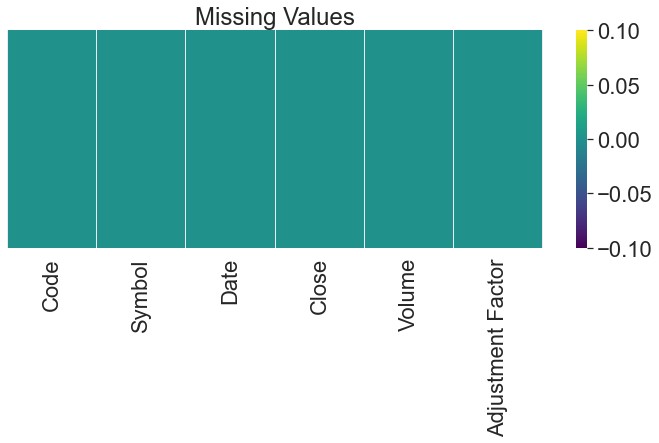

In [104]:
plt.figure(figsize=(12,4))
plt.title('Missing Values')
sns.heatmap(df.isnull(),cbar=True,cmap='viridis',yticklabels=False)

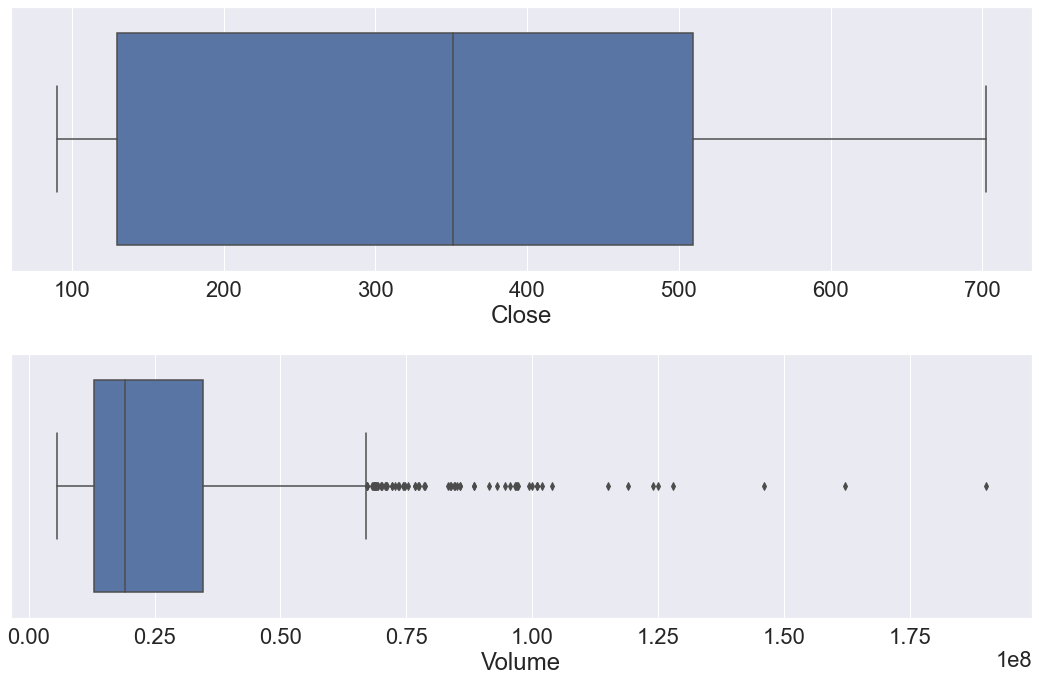

In [119]:
# Outlier Analysis
fig, axs = plt.subplots(2, figsize = (15,10))
plt1 = sns.boxplot(df[df["Symbol"]==ticker_symbol[0]]["Close"], ax = axs[0])
plt2 = sns.boxplot(df[df["Symbol"]==ticker_symbol[0]]["Volume"], ax = axs[1])
#axs.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
# Volume size is huge. Might want to put this in log scale

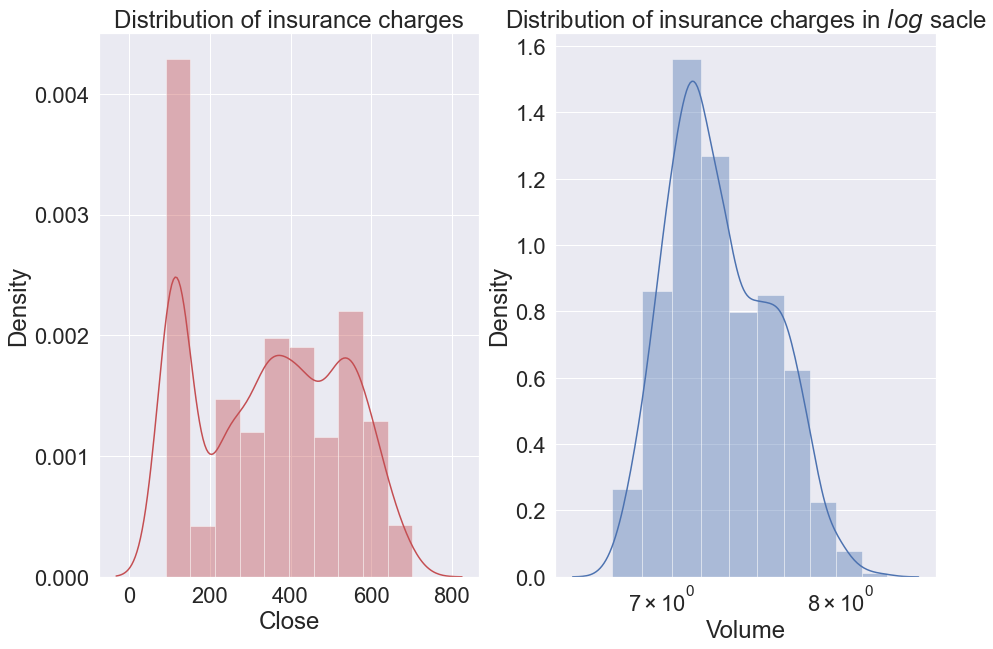

In [128]:
fig= plt.figure(figsize=(15,10))
# went with the small number of bins because less gaps and looks nicer
ax=fig.add_subplot(121)
sns.distplot(df[df["Symbol"]==ticker_symbol[0]]["Close"],bins=10,color='r',ax=ax)
ax.set_title('Distribution of Closing Price')

ax=fig.add_subplot(122)
sns.distplot(np.log10(df[df["Symbol"]==ticker_symbol[0]]["Volume"]),bins=10,color='b',ax=ax)
ax.set_title('Distribution of Trade Volume in $log$ sacle')
ax.set_xscale('log');

Conclusion: There's no missing data. The Volume sizes are large but that makes sense actually because this company is highly traded. Thee closing prices are "handwavy" more distributed uniformly than normal. Plus the scale is quite large (not as large as Volume) so this tells me the data could benefit from being transformed into something more standard normal. If not, when I train using LSTM I could encounter numerical errors such as exploding gradiants.  

I wont do anything to the Volume because I don't actually need it during my calculations. The goal is to predict the slope (Equation 1).

#### ADD SOME DATA COLUMNS

Below I detail how I added new columns to the dataset. Lets first build two new DataFrames.

In [631]:
AAPL_ordered_adjclose_df

,Code,Symbol,Date,Close,Volume,Adjustment Factor,AdjustedClose,month,day,year,AdjustedReturns
0,43030,AAPL,2010-01-04,214.01,17600000.0,0.035714,7.643214,1,4,2010,NaN
1,43030,AAPL,2010-01-05,214.38,21500000.0,0.035714,7.656429,1,5,2010,15.299643
2,43030,AAPL,2010-01-06,210.97,19700000.0,0.035714,7.534643,1,6,2010,15.191072
3,43030,AAPL,2010-01-07,210.58,17000000.0,0.035714,7.520714,1,7,2010,15.055357
4,43030,AAPL,2010-01-08,211.98,16000000.0,0.035714,7.570714,1,8,2010,15.091429
...,...,...,...,...,...,...,...,...,...,...,...
1505,43030,AAPL,2015-12-24,108.03,13600000.0,0.250000,27.007500,12,24,2015,54.160000
1506,43030,AAPL,2015-12-28,106.82,26700000.0,0.250000,26.705000,12,28,2015,53.712500
1507,43030,AAPL,2015-12-29,108.74,30900000.0,0.250000,27.185000,12,29,2015,53.890000
1508,43030,AAPL,2015-12-30,107.32,25200000.0,0.250000,26.830000,12,30,2015,54.015000


In [634]:
window = 45
AAPL_ordered_adjclose_df["AdjustedReturns45"] = AAPL_ordered_adjclose_df.AdjustedClose.rolling(window=window).sum()
print(AAPL_ordered_adjclose_df.dropna())        


       Code Symbol       Date   Close      Volume  Adjustment Factor  \
44    43030   AAPL 2010-03-09  223.02  32900000.0           0.035714   
45    43030   AAPL 2010-03-10  224.84  21300000.0           0.035714   
46    43030   AAPL 2010-03-11  225.50  14500000.0           0.035714   
47    43030   AAPL 2010-03-12  226.60  14900000.0           0.035714   
48    43030   AAPL 2010-03-15  223.84  17600000.0           0.035714   
...     ...    ...        ...     ...         ...                ...   
1505  43030   AAPL 2015-12-24  108.03  13600000.0           0.250000   
1506  43030   AAPL 2015-12-28  106.82  26700000.0           0.250000   
1507  43030   AAPL 2015-12-29  108.74  30900000.0           0.250000   
1508  43030   AAPL 2015-12-30  107.32  25200000.0           0.250000   
1509  43030   AAPL 2015-12-31  105.26  40900000.0           0.250000   

      AdjustedClose  month  day  year  AdjustedReturns  AdjustedReturns45  
44         7.965000      3    9  2010        15.789286     

In [642]:
AAPL_ordered_adjclose_df

,Code,Symbol,Date,Close,Volume,Adjustment Factor,AdjustedClose,month,day,year,AdjustedReturns,AdjustedReturns45
0,43030,AAPL,2010-01-04,214.01,17600000.0,0.035714,7.643214,1,4,2010,NaN,NaN
1,43030,AAPL,2010-01-05,214.38,21500000.0,0.035714,7.656429,1,5,2010,15.299643,NaN
2,43030,AAPL,2010-01-06,210.97,19700000.0,0.035714,7.534643,1,6,2010,15.191072,NaN
3,43030,AAPL,2010-01-07,210.58,17000000.0,0.035714,7.520714,1,7,2010,15.055357,NaN
4,43030,AAPL,2010-01-08,211.98,16000000.0,0.035714,7.570714,1,8,2010,15.091429,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1505,43030,AAPL,2015-12-24,108.03,13600000.0,0.250000,27.007500,12,24,2015,54.160000,1304.20125
1506,43030,AAPL,2015-12-28,106.82,26700000.0,0.250000,26.705000,12,28,2015,53.712500,1302.03125
1507,43030,AAPL,2015-12-29,108.74,30900000.0,0.250000,27.185000,12,29,2015,53.890000,1299.44625
1508,43030,AAPL,2015-12-30,107.32,25200000.0,0.250000,26.830000,12,30,2015,54.015000,1297.45625


In [639]:
sp500_ordered_adjclose_df["AdjustedReturns45"] = sp500_ordered_adjclose_df.AdjustedClose.rolling(window=window).sum()
print(sp500_ordered_adjclose_df.dropna())   

       Code Symbol       Date   Close       Volume  Adjustment Factor  \
44    59751    SPY 2010-03-09  114.46  155000000.0                1.0   
45    59751    SPY 2010-03-10  114.97  186000000.0                1.0   
46    59751    SPY 2010-03-11  115.45  161000000.0                1.0   
47    59751    SPY 2010-03-12  115.46  162000000.0                1.0   
48    59751    SPY 2010-03-15  115.49  147000000.0                1.0   
...     ...    ...        ...     ...          ...                ...   
1505  59751    SPY 2015-12-24  205.68   48500000.0                1.0   
1506  59751    SPY 2015-12-28  205.21   65900000.0                1.0   
1507  59751    SPY 2015-12-29  207.40   92600000.0                1.0   
1508  59751    SPY 2015-12-30  205.93   63300000.0                1.0   
1509  59751    SPY 2015-12-31  203.87  115000000.0                1.0   

      AdjustedClose  month  day  year  AdjustedReturns  AdjustedReturns45  
44           114.46      3    9  2010          

CPU times: user 312 ms, sys: 135 ms, total: 447 ms
Wall time: 548 ms


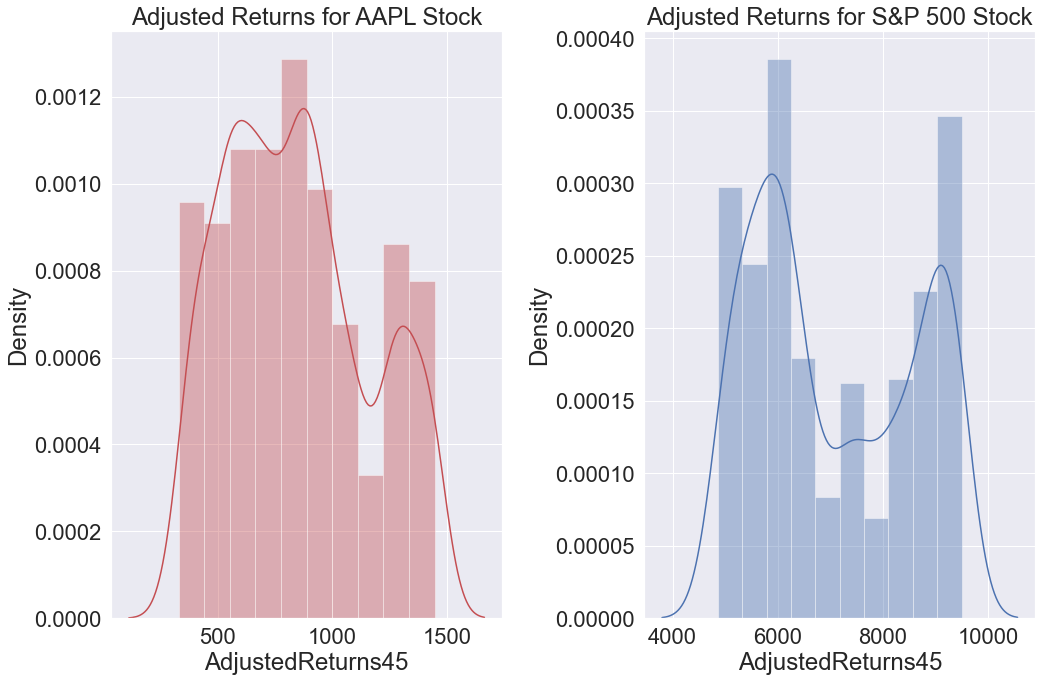

In [640]:
%%time
fig= plt.figure(figsize=(15,10))
ax=fig.add_subplot(121)
sns.distplot(AAPL_ordered_adjclose_df.dropna().AdjustedReturns45,bins=10,color='r',ax=ax)
ax.set_title('Adjusted Returns for AAPL Stock')

ax=fig.add_subplot(122)
sns.distplot(sp500_ordered_adjclose_df.dropna().AdjustedReturns45,bins=10,color='b',ax=ax)
ax.set_title('Adjusted Returns for S&P 500 Stock')
plt.tight_layout()

CPU times: user 41.9 ms, sys: 7.2 ms, total: 49.1 ms
Wall time: 46.5 ms


Text(0, 0.5, 'AAPL Return')

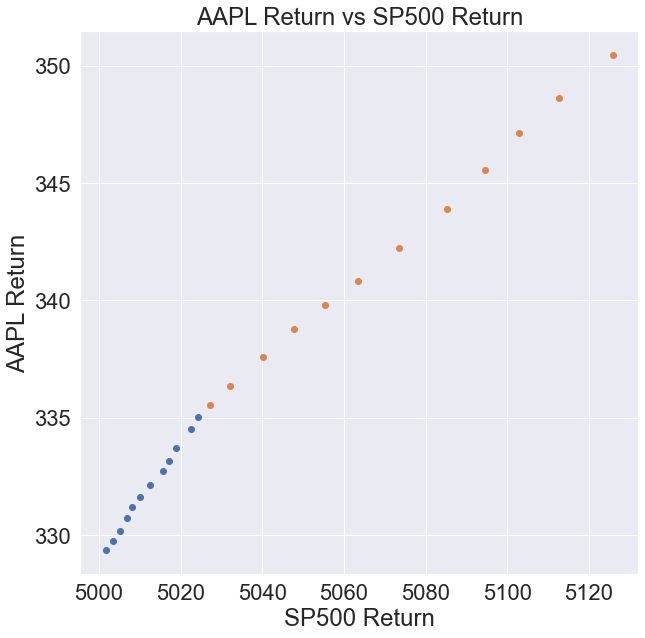

In [653]:
%%time
#i=1

# The closer look at the relationship between the stock returns 
plt.figure(figsize=(10,10))
plt.title("AAPL Return vs SP500 Return")
for i in range(2):
    plt.scatter(x=sp500_ordered_adjclose_df.dropna().AdjustedReturns45.to_numpy()[12*i:12+i*12], y=AAPL_ordered_adjclose_df.dropna().AdjustedReturns45.to_numpy()[12*i:12+i*12])
plt.xlabel("SP500 Return")
plt.ylabel("AAPL Return")

In [249]:
%%time
# I build an Apple/sp500 df... probs should change to generic name but too scared at this point something will break...
AAPL_df = STOCK_df(DataFrame=df, ticker_symbol=ticker_symbol[0])
sp500_df = STOCK_df(DataFrame=df, ticker_symbol=sp500)

# Use the functions I defined above to do the work
AAPL_adjclose_df = buildAdjustClosingColumn(DataFrame=AAPL_df, ticker_symbol=None)
AAPL_ordered_adjclose_df = orderStockByDate(DataFrame=AAPL_adjclose_df)
AAPL_returns_df = buildStockReturnsColumn(DataFrame=AAPL_ordered_adjclose_df, ticker_symbol=None)

sp500_adjclose_df = buildAdjustClosingColumn(DataFrame=sp500_df, ticker_symbol=None)
sp500_ordered_adjclose_df = orderStockByDate(DataFrame=sp500_adjclose_df)
sp500_returns_df = buildStockReturnsColumn(DataFrame=sp500_ordered_adjclose_df, ticker_symbol=None)


         Code Symbol        Date    Close      Volume  Adjustment Factor  \
376     43030   AAPL    8/3/2015  118.440  70000000.0           0.250000   
411     43030   AAPL  11/13/2014  112.820  59500000.0           0.250000   
948     43030   AAPL    6/3/2013  450.720  13300000.0           0.035714   
978     43030   AAPL   7/28/2010  260.960  18600000.0           0.035714   
1093    43030   AAPL   6/21/2013  413.500  17200000.0           0.035714   
...       ...    ...         ...      ...         ...                ...   
290902  43030   AAPL  12/13/2013  554.430  11900000.0           0.035714   
290968  43030   AAPL  12/10/2015  116.170  29200000.0           0.250000   
290985  43030   AAPL   6/16/2015  127.600  31500000.0           0.250000   
291076  43030   AAPL   6/19/2015  126.600  54700000.0           0.250000   
291205  43030   AAPL   6/25/2012  570.765  10900000.0           0.035714   

        AdjustedClose  
376         29.610000  
411         28.205000  
948         16.

In [256]:
AAPL_returns_df.describe()

,Code,Close,Volume,Adjustment Factor,AdjustedClose,month,day,year,AdjustedReturns
count,1509.0,1509.000000,1.509000e+03,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000
mean,43030.0,347.782600,2.650419e+07,0.091948,18.806625,6.552684,15.715706,2012.502319,37.600877
std,0.0,177.613087,2.003891e+07,0.094307,7.081681,3.426092,8.736150,1.708778,14.162757
min,43030.0,90.280000,5.630713e+06,0.035714,6.858929,1.000000,1.000000,2010.000000,13.814036
25%,43030.0,129.960000,1.300000e+07,0.035714,12.757143,4.000000,8.000000,2011.000000,25.489643
50%,43030.0,351.540000,1.910000e+07,0.035714,18.537429,7.000000,16.000000,2013.000000,37.121786
75%,43030.0,509.589200,3.460000e+07,0.250000,23.980357,10.000000,23.000000,2014.000000,47.930000
max,43030.0,702.100000,1.900000e+08,0.250000,33.250000,12.000000,31.000000,2015.000000,66.292500


In [255]:
sp500_returns_df.describe()

,Code,Close,Volume,Adjustment Factor,AdjustedClose,month,day,year,AdjustedReturns
count,1509.0,1509.000000,1.509000e+03,1509.0,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000
mean,59751.0,157.247928,1.545306e+08,1.0,157.247928,6.552684,15.715706,2012.502319,314.435856
std,0.0,34.572806,7.946318e+07,0.0,34.572806,3.426092,8.736150,1.708778,69.127542
min,59751.0,102.200000,3.730000e+07,1.0,102.200000,1.000000,1.000000,2010.000000,204.960000
25%,59751.0,128.020000,1.020000e+08,1.0,128.020000,4.000000,8.000000,2011.000000,256.010000
50%,59751.0,146.620000,1.360000e+08,1.0,146.620000,7.000000,16.000000,2013.000000,293.000000
75%,59751.0,192.895000,1.850000e+08,1.0,192.895000,10.000000,23.000000,2014.000000,386.390000
max,59751.0,213.500000,7.180000e+08,1.0,213.500000,12.000000,31.000000,2015.000000,426.490000


CPU times: user 329 ms, sys: 51.6 ms, total: 380 ms
Wall time: 322 ms


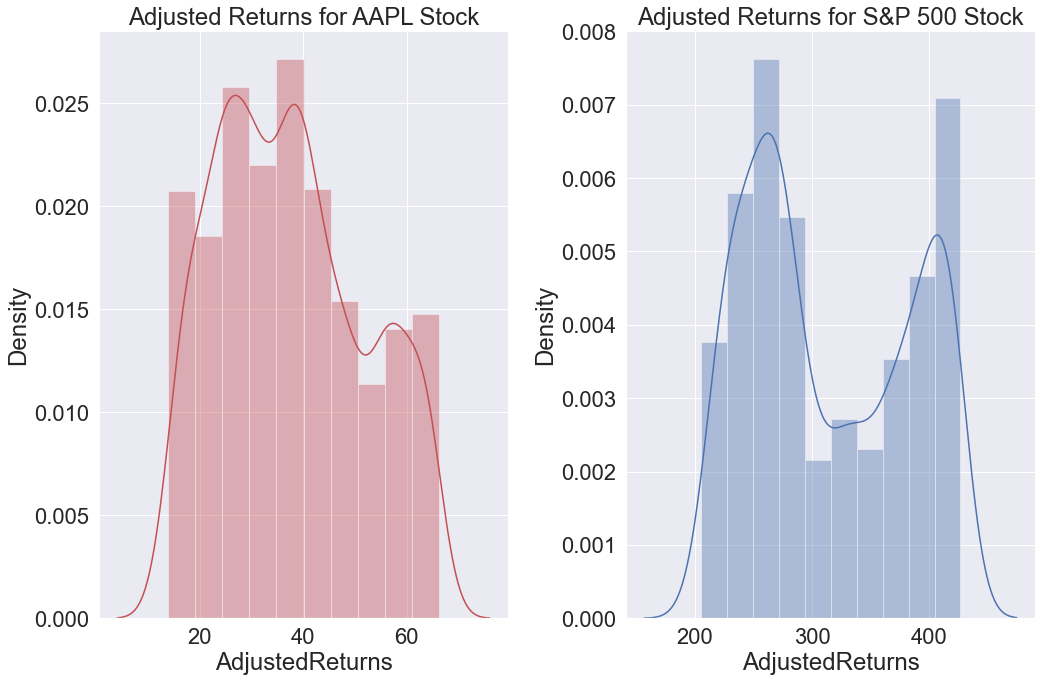

In [253]:
%%time
fig= plt.figure(figsize=(15,10))
ax=fig.add_subplot(121)
sns.distplot(AAPL_returns_df.AdjustedReturns,bins=10,color='r',ax=ax)
ax.set_title('Adjusted Returns for AAPL Stock')

ax=fig.add_subplot(122)
sns.distplot(sp500_returns_df.AdjustedReturns,bins=10,color='b',ax=ax)
ax.set_title('Adjusted Returns for S&P 500 Stock')
plt.tight_layout()

#### TRIAL 1

So, what happend here was that I just tried to calculated the beta for the entire dataset even though the returns don't look too linear. There is this structure in the plot and I believe I need to slip this into chunks.

In [301]:
# calculate beta for the entire dataset
# make some kind of one-to-one plot
beta = np.cov(sp500_returns_df.AdjustedReturns.to_numpy(), AAPL_returns_df.AdjustedReturns.to_numpy(), ddof=0 )[0][1]/np.cov(sp500_returns_df.AdjustedReturns.to_numpy(), AAPL_returns_df.AdjustedReturns.to_numpy(), ddof=0 )[1][1]
x_vals = sp500_returns_df.AdjustedReturns.to_numpy()
y_vals = 0 + beta * x_vals



Text(0, 0.5, 'AAPL Return')

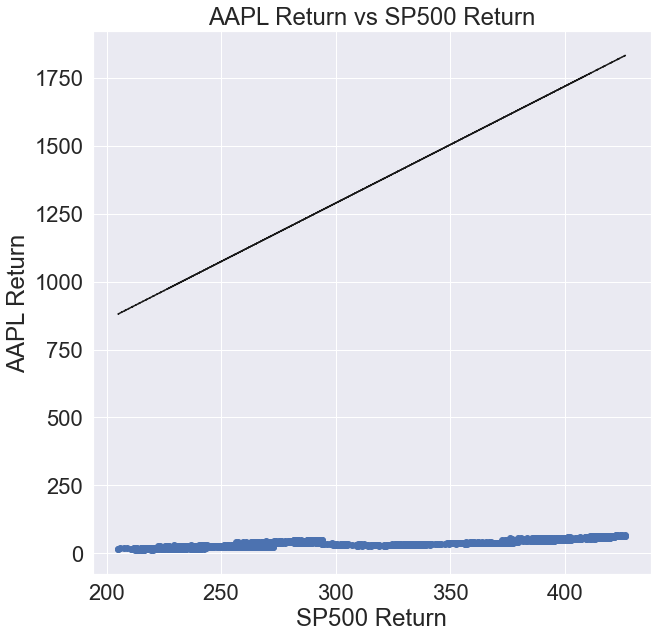

In [289]:
# The one-to-one 
plt.figure(figsize=(10,10))
plt.title("AAPL Return vs SP500 Return")
plt.scatter(x=sp500_returns_df.AdjustedReturns.to_numpy(), y=AAPL_returns_df.AdjustedReturns.to_numpy())
plt.plot(x_vals, y_vals, 'k--')
#plt.scatter(x=sp500_returns_df.AdjustedReturns.to_numpy()//10, y=AAPL_returns_df.AdjustedReturns.to_numpy())
plt.xlabel("SP500 Return")
plt.ylabel("AAPL Return")

This isn't looking too good at all. What I tried to do here is calculate beta for the entire histoy of the data for this particular stock and its not a good fit. This means I must have misunderstood what is being asked of me. *For day T, you should forecast the 45-day forward-looking beta (which is calculated using days T+1 through T+45)*. I'm taking this to mean, grab a smaller chunk of data and then forecast 45-days ahead.   

Also, the returns from SP500 looks like its about 10 times the size of this stock. This could be a problem during the training process. Is there a way to generalize this scaling factor for any stock? (A:...yes there is...)

Text(0, 0.5, 'AAPL Return')

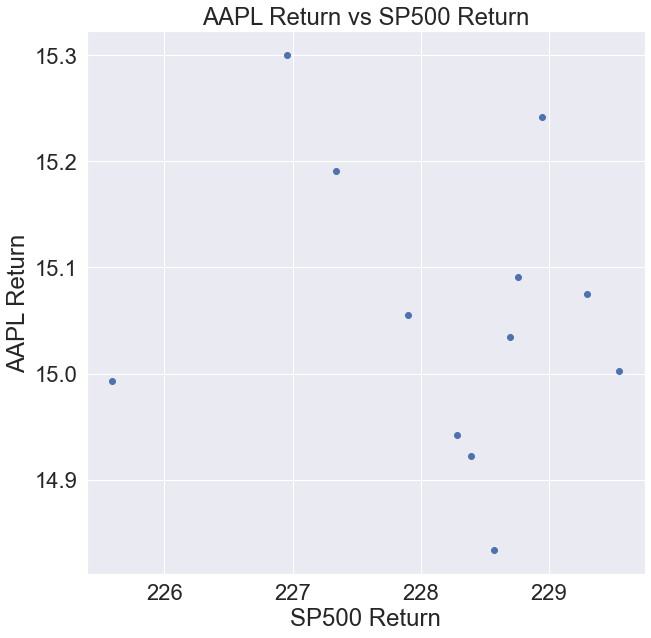

In [645]:
# The closer look at the relationship between the stock returns 
plt.figure(figsize=(10,10))
plt.title("AAPL Return vs SP500 Return")
plt.scatter(x=sp500_returns_df.AdjustedReturns.to_numpy()[:12], y=AAPL_returns_df.AdjustedReturns.to_numpy()[:12])
plt.xlabel("SP500 Return")
plt.ylabel("AAPL Return")

In [264]:
AAPL_returns_df

,Code,Symbol,Date,Close,Volume,Adjustment Factor,AdjustedClose,month,day,year,AdjustedReturns
1,43030,AAPL,2010-01-05,214.38,21500000.0,0.035714,7.656429,1,5,2010,15.299643
2,43030,AAPL,2010-01-06,210.97,19700000.0,0.035714,7.534643,1,6,2010,15.191072
3,43030,AAPL,2010-01-07,210.58,17000000.0,0.035714,7.520714,1,7,2010,15.055357
4,43030,AAPL,2010-01-08,211.98,16000000.0,0.035714,7.570714,1,8,2010,15.091429
5,43030,AAPL,2010-01-11,210.11,16500000.0,0.035714,7.503929,1,11,2010,15.074643
...,...,...,...,...,...,...,...,...,...,...,...
1505,43030,AAPL,2015-12-24,108.03,13600000.0,0.250000,27.007500,12,24,2015,54.160000
1506,43030,AAPL,2015-12-28,106.82,26700000.0,0.250000,26.705000,12,28,2015,53.712500
1507,43030,AAPL,2015-12-29,108.74,30900000.0,0.250000,27.185000,12,29,2015,53.890000
1508,43030,AAPL,2015-12-30,107.32,25200000.0,0.250000,26.830000,12,30,2015,54.015000


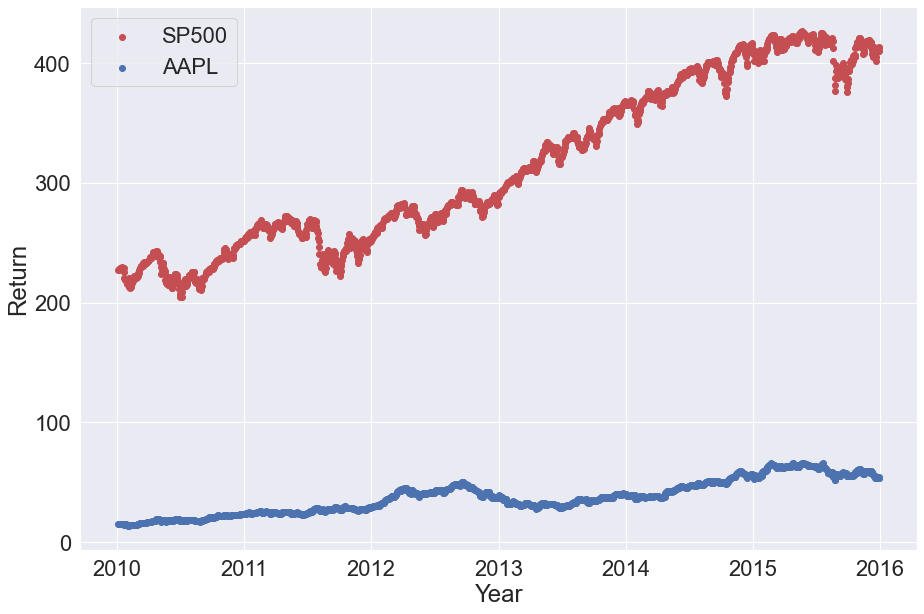

In [291]:
plt.figure(figsize=(15,10))
plt.scatter(x=sp500_returns_df.Date.to_numpy(), y=sp500_returns_df.AdjustedReturns.to_numpy(),c='r', label="SP500")
plt.scatter(x=AAPL_returns_df.Date.to_numpy(), y=AAPL_returns_df.AdjustedReturns.to_numpy(),c='b', label="AAPL")
plt.xlabel("Year")
plt.ylabel("Return")
plt.legend()
plt.show()

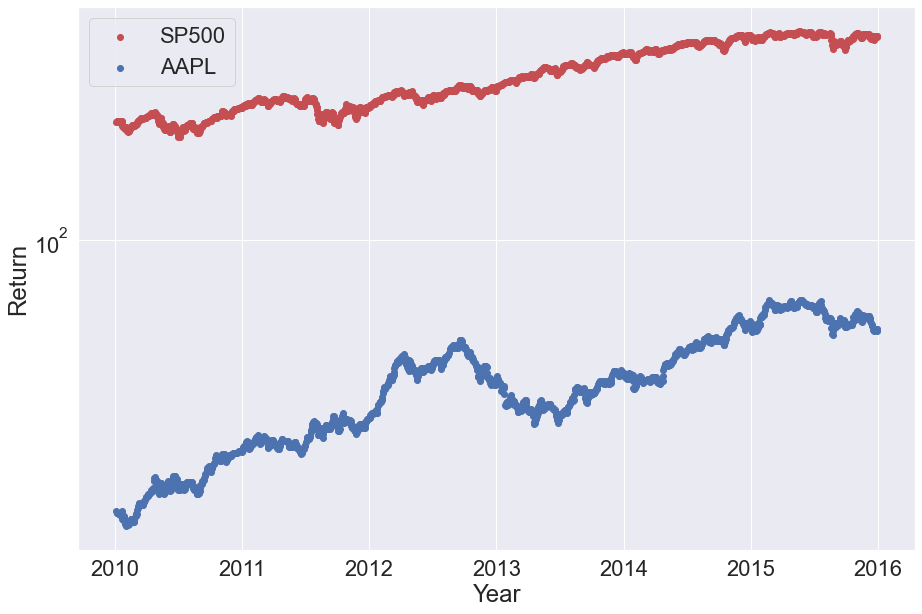

In [629]:
plt.figure(figsize=(15,10))
plt.scatter(x=sp500_returns_df.Date.to_numpy(), y=sp500_returns_df.AdjustedReturns.to_numpy(),c='r', label="SP500")
plt.scatter(x=AAPL_returns_df.Date.to_numpy(), y=AAPL_returns_df.AdjustedReturns.to_numpy(),c='b', label="AAPL")
plt.xlabel("Year")
plt.ylabel("Return")
plt.yscale('log')
plt.legend()
plt.show()

The scatter plot looks reasonable. Returns as a function of years.

### DATA CLEANING/ SCALING

Like I mentioned above, the returns are far too large and need to be place on the samee scale. The MinMaxscaler is a type of scaler that scales the minimum and maximum values to be 0 and 1 respectively. While the StandardScaler scales all values between min and max so that they fall within a range from min to max. During my phd program we kept our values between 0 and 1 so that's what I did here. If I hhad more time I would like to see how this would affect my results.   
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html  

The transformation is given by:  

\begin{equation}
X_{std} = \frac{(X - X.min(axis=0))}{(X.max(axis=0) - X.min(axis=0))}
\end{equation}

\begin{equation}
X_{scaled} = X_{std} * ({max} - {min}) + {min}
\end{equation}

In [365]:
%%time
# Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_sp500_returns = scaler.fit_transform(sp500_returns_df.filter(['AdjustedReturns']).values)
scaled_AAPL_returns = scaler.fit_transform(AAPL_returns_df.filter(['AdjustedReturns']).values)

CPU times: user 8.29 ms, sys: 28.4 ms, total: 36.7 ms
Wall time: 54.4 ms


In [624]:
sp500_returns_df.filter(['AdjustedReturns']).values

array([[226.96],
       [227.34],
       [227.9 ],
       ...,
       [412.61],
       [413.33],
       [409.8 ]])

In [626]:
sp500_returns_df.filter(['AdjustedReturns']).values.min()

204.95999999999972

In [627]:
sp500_returns_df.filter(['AdjustedReturns']).values.max()

426.49000000000024

In [628]:
(sp500_returns_df.filter(['AdjustedReturns']).values- sp500_returns_df.filter(['AdjustedReturns']).values.min())/(sp500_returns_df.filter(['AdjustedReturns']).values.max()-sp500_returns_df.filter(['AdjustedReturns']).values.min())

array([[0.09930935],
       [0.10102469],
       [0.10355257],
       ...,
       [0.93734483],
       [0.94059495],
       [0.92466032]])

In [623]:
scaler.fit_transform(sp500_returns_df.filter(['AdjustedReturns']).values)

array([[0.09930935],
       [0.10102469],
       [0.10355257],
       ...,
       [0.93734483],
       [0.94059495],
       [0.92466032]])

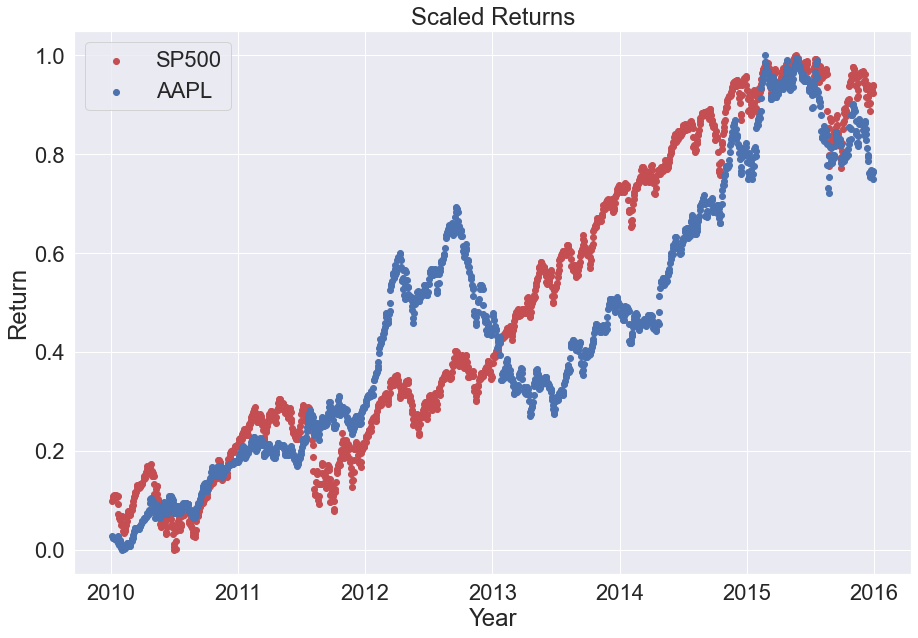

In [366]:
plt.figure(figsize=(15,10))
plt.title("Scaled Returns")
plt.scatter(x=sp500_returns_df.Date.to_numpy(), y=scaled_sp500_returns,c='r', label="SP500")
plt.scatter(x=AAPL_returns_df.Date.to_numpy(), y=scaled_AAPL_returns,c='b', label="AAPL")
plt.xlabel("Year")
plt.ylabel("Return")
plt.legend()
plt.show()

CPU times: user 344 ms, sys: 41.7 ms, total: 386 ms
Wall time: 369 ms


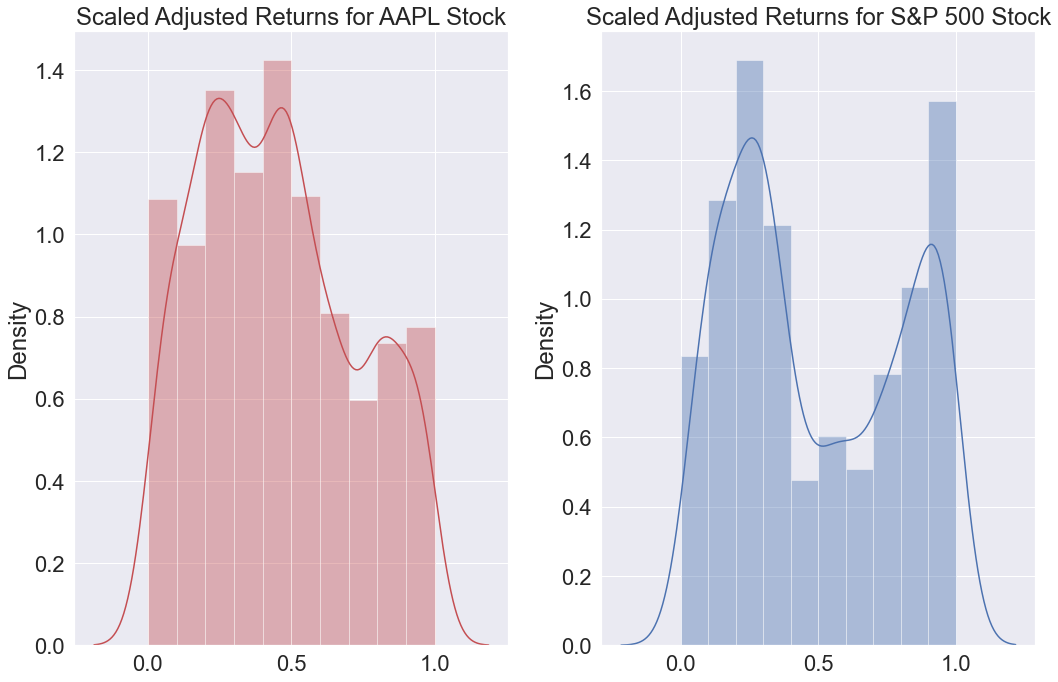

In [487]:
%%time
fig= plt.figure(figsize=(15,10))
ax=fig.add_subplot(121)
sns.distplot(scaled_AAPL_returns,bins=10,color='r',ax=ax)
ax.set_title('Scaled Adjusted Returns for AAPL Stock')

ax=fig.add_subplot(122)
sns.distplot(scaled_sp500_returns,bins=10,color='b',ax=ax)
ax.set_title('Scaled Adjusted Returns for S&P 500 Stock')
plt.tight_layout()

#### TRANSFORMATION

Returns aren't Normal...

Below I try to do something about it. I tried using the Box-Cox

The boxcox() implements the Box-Cox method. It takes an argument, called lambda, that controls the type of transform to perform.

Below are some common values for lambda:

lambda = -1. is a reciprocal transform.
lambda = -0.5 is a reciprocal square root transform.
lambda = 0.0 is a log transform.
lambda = 0.5 is a square root transform.
lambda = 1.0 is no transform.
For example, because we know that the data is lognormal, we can use the Box-Cox to perform the log transform by setting lambda explicitly to 0.

The Box-Cox transform is given by::

    y = (x**lmbda - 1) / lmbda,  for lmbda > 0
        log(x),                  for lmbda = 0

`boxcox` requires the input data to be positive.  Sometimes a Box-Cox
transformation provides a shift parameter to achieve this; `boxcox` does
not.  Such a shift parameter is equivalent to adding a positive constant to
`x` before calling `boxcox`.

The confidence limits returned when ``alpha`` is provided give the interval
where:

.. math::

    llf(\hat{\lambda}) - llf(\lambda) < \frac{1}{2}\chi^2(1 - \alpha, 1),

with ``llf`` the log-likelihood function and :math:`\chi^2` the chi-squared
function.


https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

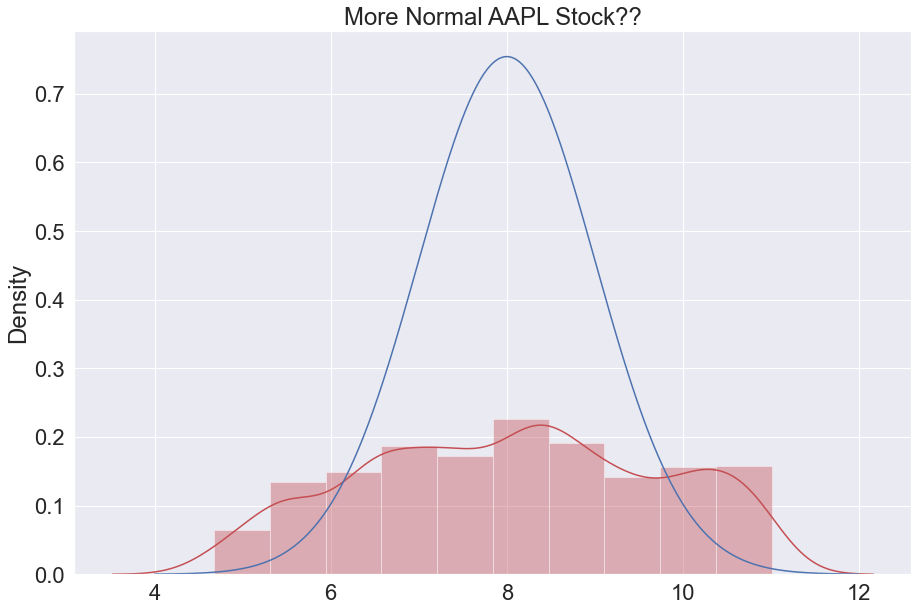

In [528]:
N = 5
x = stats.norm.rvs(size=N)
num_bins = 10
y = np.linspace(4, 12, 1000)
bin_width = (x.max() - x.min()) / num_bins

#`lmbda` is None, find the lambda that maximizes the log-likelihood function 
# and return it as the second output argument.
bc_AAPL_returns,_ = stats.boxcox(AAPL_returns_df.AdjustedReturns.to_numpy(), lmbda=None, alpha=None)
plt.figure(figsize=(15,10))
plt.title('More Normal AAPL Stock??')
sns.distplot(bc_AAPL_returns,bins=10,color='r')
plt.plot(y, stats.norm.pdf(y, loc=8) * N * bin_width)

In [529]:
stats.boxcox?

I don't think this is helping much so I wont use it...

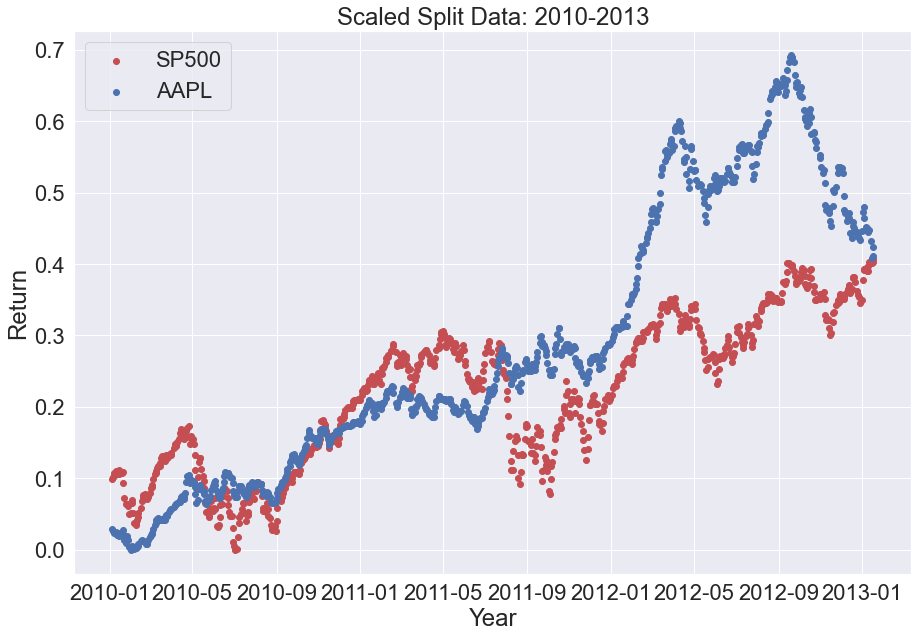

CPU times: user 629 ms, sys: 201 ms, total: 830 ms
Wall time: 1.01 s


In [488]:
%%time
random_state = 2023
plt.figure(figsize=(15,10))
plt.title("Scaled Split Data: 2010-2013")
plt.scatter(x=sp500_returns_df.Date.to_numpy()[:training_data_len], y=scaled_sp500_returns[:training_data_len],c='r', label="SP500")
plt.scatter(x=AAPL_returns_df.Date.to_numpy()[:training_data_len], y=scaled_AAPL_returns[:training_data_len],c='b', label="AAPL")
#plt.scatter(x=sp500_returns_df.Date.to_numpy()[:training_data_len], y=sp500_returns_df.AdjustedReturns.to_numpy()[:training_data_len], label="SP500")
#plt.scatter(x=AAPL_returns_df.Date.to_numpy()[:76training_data_len5], y=AAPL_returns_df.AdjustedReturns.to_numpy()[:training_data_len], label="AAPL")
plt.xlabel("Year")
plt.ylabel("Return")
plt.legend()
plt.show()

What happened here is that I split the dataset in a little over a half and then split it up into 17 chunks of 45. This will give me 17 different values for beta over the 3 year period of 2010-2013.

# MACHINE LEARNING
Like I said before, I wanted to use OLS but instead I went with NN because why wouldn't I lol. I built CNNs before but this is not the exact same. This is special kind of recurrent neural network that is capable of learning long term dependencies in data. My CNNs took advantage of localized features in the data while this exploites the sequential/time dependency of the data.  

This also means building the training dataset was a bit different. Normally I would shuffle my data but that cannot be done here because the order does matter. There were some time dependent components in the data used in my thesis but I didn't have to be as careful as I do here.

## LONG SHORT-TERM MEMORY (LSTM)
https://intellipaat.com/blog/what-is-lstm/  
is a variety of recurrent neural networks (RNNs) that is capabile of learning long term dependencies in data is achieved because the recurring module of the model has a combination of four layers interacting with each other.  

LSTM has feedback connections (this is the recurrent part) making it capable of processing the entire sequence of data, apart from single data points such as images. This finds application in speech recognition, machine translation, etc. LSTM is a special kind of RNN, which shows outstanding performance on a large variety of problems.  

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM  
tf.keras.layers.LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
    **kwargs
)

RESOURCES TO HELP MAKE PREDICTIONS

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/  
https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/  
https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/  
https://the-learning-machine.com/article/dl/long-short-term-memory  
https://www.kaggle.com/amarsharma768/stock-price-prediction-using-lstm/notebook

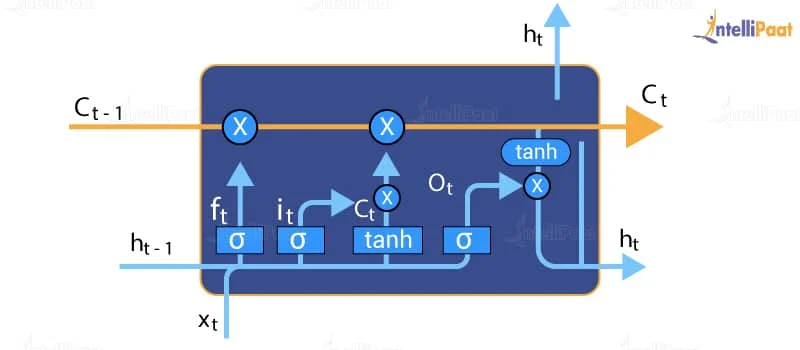
https://intellipaat.com/blog/what-is-lstm/

In [414]:
#Reshape the data and create a new dataframe with AAPL AdjReturn, SP500 AdjReturn, beta (17 of them)

X_scaled_sp500_returns = scaled_sp500_returns[:training_data_len].reshape(new_shape) #(17,45)
y_scaled_AAPL_returns = scaled_AAPL_returns[:training_data_len].reshape(new_shape) #(17,45)
beta_list = [beta(stock_returns_array=y[i],sp500_returns_array=X[i]) for i in range(len(X_scaled_sp500_returns))]

print(beta_list)

[2.027481331831631, 0.5299449044073127, 0.7113968540409206, 1.4931797348967248, 1.388140020533037, 1.787764721177151, 1.2169566072728888, 1.2331601377608286, 0.053794978587945116, 0.569332299779323, 0.6946393824744328, 0.6278372353257695, 0.21124990700030216, 0.7432464335814614, 0.5096641128710119, 0.3015497831020469, -0.3508826487629403]


In [424]:
(2.03-1)*100

102.99999999999999

#### Interpreting Results

Let's look at some plots. I looks like from the plot beta below, it's decreasing. It's going from 2 to some negative number and if we remember from the veery beginning of the notebook:   

A beta value that is less than 1.0 means that the security is theoretically less volatile than the market. Including this stock in a portfolio makes it less risky than the same portfolio without the stock.  

A beta that is greater than 1.0 indicates that the security's price is theoretically more volatile than the market. For example, AAPL's beta at the highest point in this dataset is 2.03, it is assumed to be 103% more volatile than the market. The article below said Jobs was sick in 2009 and then in 2010 the came up with a solution to the Amazon Kindle and its share spiked. So, this makes sense.   

https://www.businessinsider.com/apple-comeback-story-2010-10#2010-the-year-of-the-ipad-14  

A beta of -1.0 means that the stock is inversely correlated to the market benchmark on a 1:1 basis. This stock could be thought of as an opposite, mirror image of the benchmark’s trends. Put options and inverse ETFs are designed to have negative betas. There are also a few industry groups, like gold miners, where a negative beta is also common.  

https://www.cultofmac.com/257364/entire-year-apple-news-one-post/#:~:text=Apple%20released%20its%20financial%20results,AAPL%20shares%20on%20another%20slide.  

The article above talks about what happend all of 2013. Cook started his 2nd year as CEO at Apple.  

Text(0, 0.5, 'Beta')

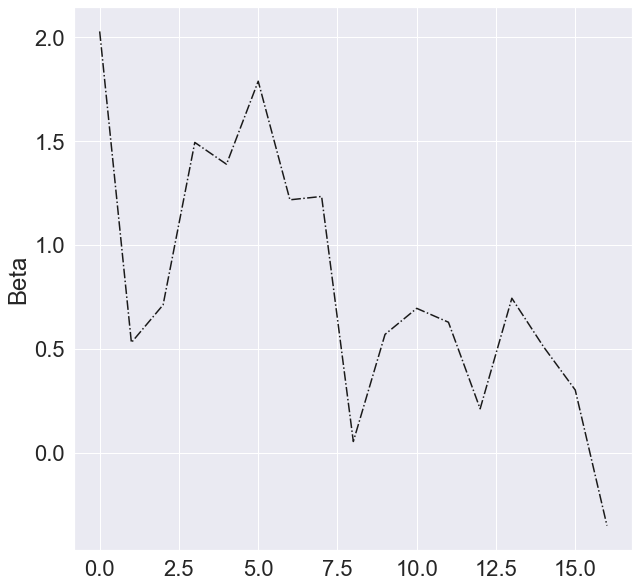

In [419]:
plt.figure(figsize=(10,10))
plt.plot(beta_list,"k-.")
plt.ylabel("Beta")

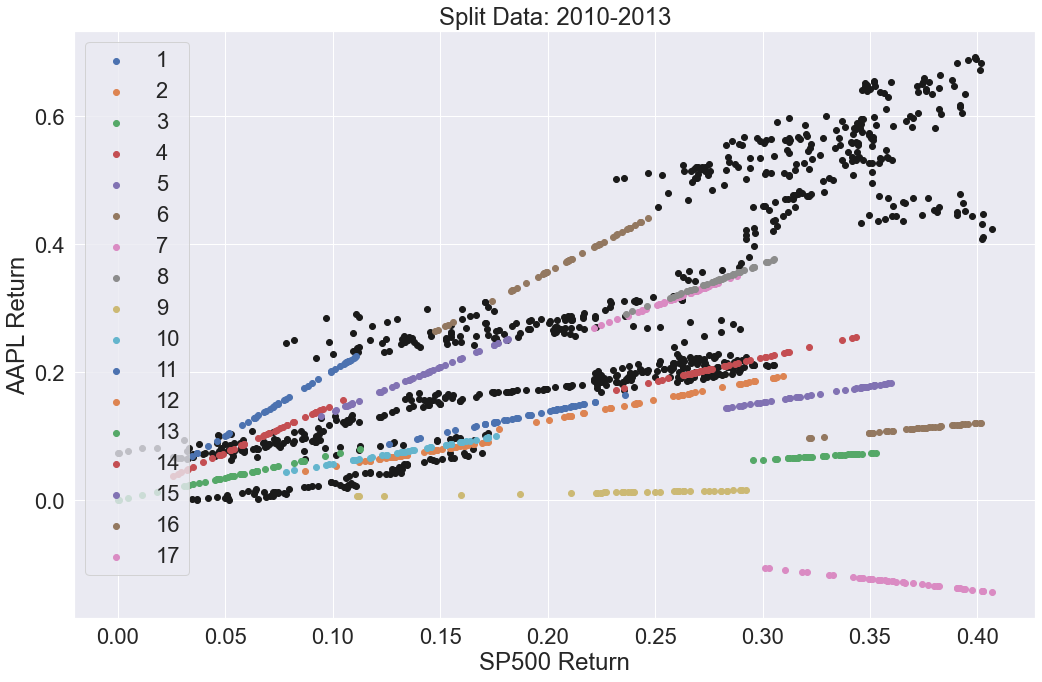

CPU times: user 1.25 s, sys: 78.2 ms, total: 1.33 s
Wall time: 1.13 s


In [409]:
%%time
yval = [beta_list[i]*X[i] for i in range(len(scaled_sp500_returns[:training_data_len].reshape(new_shape)))]

plt.figure(figsize=(15,10))
plt.title("Split Data: 2010-2013")
plt.scatter(x=scaled_sp500_returns[:training_data_len], y=scaled_AAPL_returns[:training_data_len],c='k')#, label="SP500 vs AAPL")

for i in range(new_shape[0]):
    plt.scatter(x=X[i], y=yval[i], label=str(i+1))

plt.xlabel("SP500 Return")
plt.ylabel("AAPL Return")
plt.legend()

plt.tight_layout()
plt.show()

I plot the line with a slope beta just so we can get a feel of directions...

In [428]:
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = scaled_AAPL_returns[:training_data_len].reshape(new_shape), np.array(beta_list)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))#(17,45,1)
print("Training Data Shape,",x_train.shape)
print("Labels Shape,",y_train.shape)

Training Data Shape, (17, 45, 1)
Labels Shape, (17,)


### BUILD AND TRAIN MODELS

In [473]:
%%time

# BUILD LSTM MODEL
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

# COMPILE MODEL
model.compile(optimizer='adam', loss='mean_squared_error')

# TRAIN MODEL
model.fit(x_train, y_train, batch_size=1, epochs=10, verbose=0)

Epoch 1/10
17/17 [==============================] - 3s 26ms/step - loss: 0.8648
Epoch 2/10
17/17 [==============================] - 0s 25ms/step - loss: 0.5882
Epoch 3/10
17/17 [==============================] - 0s 24ms/step - loss: 0.4875
Epoch 4/10
17/17 [==============================] - 0s 25ms/step - loss: 0.4657
Epoch 5/10
17/17 [==============================] - 0s 24ms/step - loss: 0.4095
Epoch 6/10
17/17 [==============================] - 0s 25ms/step - loss: 0.3546
Epoch 7/10
17/17 [==============================] - 0s 25ms/step - loss: 0.3012
Epoch 8/10
17/17 [==============================] - 0s 25ms/step - loss: 0.3220
Epoch 9/10
17/17 [==============================] - 0s 24ms/step - loss: 0.2939
Epoch 10/10
17/17 [==============================] - 0s 24ms/step - loss: 0.2617
CPU times: user 11.9 s, sys: 3.29 s, total: 15.1 s
Wall time: 7.84 s


In [444]:
# CREATE TEST DATASETS
x_test = scaled_AAPL_returns[training_data_len:training_data_len+90].reshape(new_shape_test) #np.array(x_test)
test_data = scaled_sp500_returns[training_data_len:training_data_len+90].reshape(new_shape_test)

y_test = [beta(stock_returns_array=x_test[i],sp500_returns_array=test_data[i]) for i in range(len(test_data))]
print("Test Labels", y_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

Test Labels [-0.44472104205461427, 0.7489807421378738]


In [447]:
y_test

[-0.44472104205461427, 0.7489807421378738]

### PREDICTIONS

In [448]:
# MAKE PREDICTIONS 
predictions = model.predict(x_test, verbose=0)

# SCALE PREDICTIONS BACK
#predictions = scaler.inverse_transform(predictions)
print("Predictions", predictions)

# CALCULATE RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE", rmse)

Predictions [[0.7028731 ]
 [0.70668495]]
RMSE 0.8134222364827063


In [452]:
predictions.shape

(2, 1)

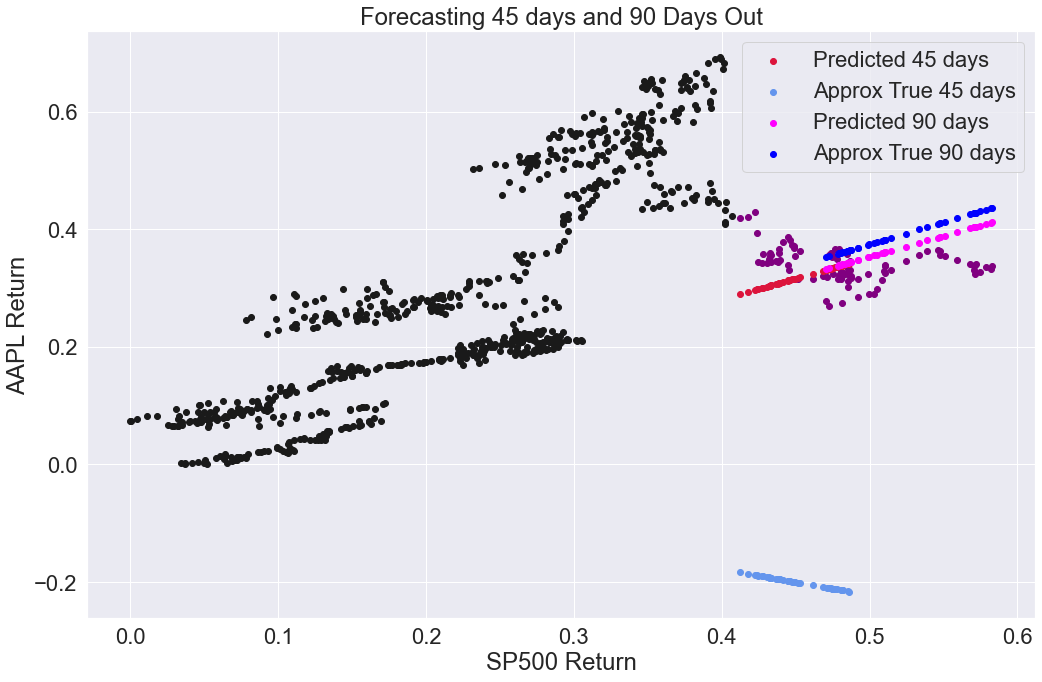

CPU times: user 848 ms, sys: 44.1 ms, total: 892 ms
Wall time: 538 ms


In [471]:
%%time
yval_pred = [predictions[i]*test_data[i] for i in range(len(x_test))]
yval_test = [y_test[i]*test_data[i] for i in range(len(x_test))]

plt.figure(figsize=(15,10))
plt.title("Forecasting 45 days and 90 Days Out")
plt.scatter(x=scaled_sp500_returns[:training_data_len], y=scaled_AAPL_returns[:training_data_len],c='k')#, label="SP500 vs AAPL")
plt.scatter(x=scaled_sp500_returns[training_data_len:training_data_len+days*len(x_test)], y=scaled_AAPL_returns[training_data_len:training_data_len+days*len(x_test)],c='purple')
#https://matplotlib.org/stable/gallery/color/named_colors.html
c1 = ["crimson", "magenta"]
c2 = ["cornflowerblue", "blue"]
for i in range(len(x_test)):
    plt.scatter(x=test_data[i], y=yval_pred[i], label="Predicted "+str(45*(i+1))+" days", c=c1[i])
    plt.scatter(x=test_data[i], y=yval_test[i], label="Approx True "+str(45*(i+1))+" days", c=c2[i])

plt.xlabel("SP500 Return")
plt.ylabel("AAPL Return")
plt.legend()

plt.tight_layout()
plt.show()

# PROJECT SUMMARY AND CONCLUSION  

### GOAL

Build a model that will predict the future beta of each stock in the dataset to “SPY”.

### SUMMARY

What this notebook does is show you how to read in a csv file, YOU have to pick your stock and you have to specify the training data and range by index. I guess it wouuld be nicer to specify dates instead of indicies.  

Initially I thought I have to predict a single beta for the entire dataset but realized that I don't think thats possible. Then I decided to split the data up into multiples of 45 because I am trying to predict values 45 business days out. There were 1509 data points for the stock I picked (AAPL) but during the training process I did not use all of them. I only used (17*49=) 833 so technically I only had 17 data points which isn't a ton.  

Feature egineering techniques were used. I needed to calculate and build a column for the adusted closing price using the Adjustment Factor in the data. After that I was able to calculate the adjusted returns (I used the hhiint that was provided pandas rolling. I didn't use the shift functions... idk... It's like when you are pulding something form Ikea and you have one unused screw. I hope this didn't mess things up). I also needeed to order my stock by date because everything was shuffled up.

In order to calculate beta I had to makes some assumtions. Unfortunately, not all of them were met. Box-Cox transormation didn't seem to help make the returns noraml so I didn't use that in my analysis which Im sure affected my results negtively.     

1. The beta coefficient theory assumes that stock returns are normally distributed from a statistical perspective.   
    My returns were not normally distributed. I tried using the Box-Cox transormation but I couldn't get it to be any help and considering the fact that I am almost out of time I stopped trying.  
2. The return on the ith investment or individual stock, R_e, is a random variable. ✅   
3. The return on the market as a whole, R_M, is also a random variable.✅   
4. Seasonality - Fourier transforms allow us to make an amplitude-based series into a frequency-based series. Then we can see if there are peaks
    - calculates the difference between the current value and its value in the previous season.

The Capital Asset Pricing Model (CAPM) describes individual stock returns as a function of the overall market’s returns. There is a risk free rate term that I did not account for in my analysis. I essentially set it equal to zero.  
https://corporatefinanceinstitute.com/resources/data-science/beta-coefficient/  

I initially wanted to train to models OLS and LSTM because that's what I saw all over the internet but ran out of time and only build and trained a LSTM model.

### RESULTS
45-day out predicitons did not do well but the 90-day looks good. It would be interesting to retrain the model maybe in like a loop where I can append chunks of 45-day data to the end of the training dataset to see how the model preditions behave.

### THINGS ID EXPLORE WITH MORE TIME
1. Figure out a better way to transform the returns so they are uniform.  
2. Risk-free rate?  
3. Build and train OLS Model.   
4. Tune LSTM model.   
5. Maybe some other model?  
6. Understand how my predicted beta values change as I append data to my training dataset.   
7. Instead of splitting data by index, come up with a smart way to do it by date.  
8. Do all of this for other stocks.  

# REFERENCES


----
Title: "*Investigating Use of Beta Coefficients for Stock Predictions*"
Author: Jeffrey Swensen
Date: 2015
Link: https://core.ac.uk/download/pdf/232670521.pdf

----